# Regression with Different Output Format under Various Data Conditions

In this experience, we test the following output format for regression task under several different data coditions.
- Numerical output
- Regression as classification (grid-out)

The data coditions include:
- Sparse (few data)
- Grouped
  - Biased (parallel data)
  - Completely different mode, uncorrelated data (cross)
  - Partially diversed (split)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
def draw_func(func_in, x_min=-5, x_max=5, mark='r--', linewidth=1, label='func'):
    n_sample = 100
    X_func = np.linspace(x_min, x_max, n_sample).reshape(n_sample, 1)
    y_func = func_in(X_func)
    plt.plot(X_func, y_func, mark, linewidth=linewidth, label=label)

Generate polynomial data

In [3]:
poly_a1 = 5.0
# poly_a1 = -10.0 # 5.0
def func_0(X): # Reference
    return 0.5 * X**3 + 0.5 * X**2 + (poly_a1)*X + 2
def func_1(X): # Variation 1: parellel
    return 0.5 * X**3 + 0.5 * X**2 + (poly_a1)*X + 30
def func_2(X): # Variation 2: cross
    return -0.5 * X**3 + 0.5 * X**2 + (poly_a1)*X + 30
def func_3(X): # Variation 3: slightly split
    return 0.3 * X**3 + 1.0 * X**2 + (poly_a1)*X + 15 

In [4]:
func_dict = dict()
func_dict["f1"] = func_0
# func_dict["f2"] = func_1
# func_dict["f2"] = func_2
func_dict["f2"] = func_3

# Average line
func_dict["f_avg"] = ( lambda X: 0.5*func_dict["f1"](X) + 0.5*func_dict["f2"](X) )

In [5]:
def draw_normal_func(func_dict):
    draw_func(func_dict["f1"], mark='c:', label="f1")
    draw_func(func_dict["f2"], mark='g:', label="f2")
    draw_func(func_dict["f_avg"], mark='m--', label="f_avg")

In [6]:
np.random.seed(42)
m = 100 # 50 # 100 # 200
m_train = m // 5 * 4
print("(m, m_train) = (%d, %d)" % (m, m_train))

# Input
is_gapped = True
# is_gapped = False
#
if not is_gapped:
    X_data = 10 * np.random.rand(m, 1) - 5 # Note: X is randomly sampled, so we don't need to shuffle the data again
else:
    X_data = np.concatenate( (np.linspace(-5.0, -2.0, m//2), np.linspace(2.0, 5.0, m-m//2)) )
    X_data = X_data.reshape((m,1))
    np.random.shuffle(X_data)

# Output
is_multiout = True
# is_multiout = False
if is_multiout:
    m_h = m // 2
    X_data_1 = X_data[:m_h]
    X_data_2 = X_data[m_h:]
    y_data_pure_1 = func_dict["f1"](X_data_1) 
    y_data_pure_2 = func_dict["f2"](X_data_2) 
    y_data_pure = np.vstack([y_data_pure_1, y_data_pure_2])
    print("y_data_pure.shape = %s" % str(y_data_pure.shape))
else:        
    y_data_pure = 0.5 * X_data**3 + 0.5 * X_data**2 + X_data + 2 

# Label (+noise)
n_stddev = 2.0
# n_stddev = 10.0
y_data = y_data_pure + np.random.randn(m, 1) * n_stddev
print("y_data.shape = %s" % str(y_data.shape))

(m, m_train) = (100, 80)
y_data_pure.shape = (100, 1)
y_data.shape = (100, 1)


In [7]:
# Method 1: simply slice
# X_train = X_data[:m_train]
# y_train = y_data[:m_train]
# X_valid = X_data[m_train:]
# y_valid = y_data[m_train:]

# Method 2: shuffle
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [8]:
print(X_train.shape)

(80, 1)


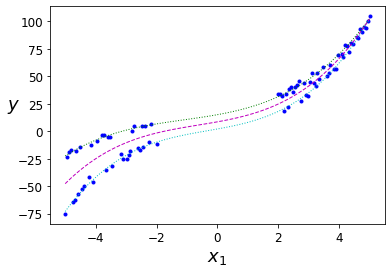

In [9]:
plt.plot(X_train, y_train, "b.")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
# plt.axis([-3, 3, 0, 10])
plt.show()

# Simple FCs (number --> number)

Build the regression model

In [10]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=0.0001, momentum=0.9)
model.compile(loss="mean_squared_error", optimizer=optimizer)

/home/benson516/ml/my_env/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [11]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

Epoch 1/100
3/3 [==============================] - 1s 250ms/step - loss: 2510.0334 - val_loss: 1745.5973
Epoch 2/100
3/3 [==============================] - 0s 70ms/step - loss: 2453.5027 - val_loss: 1666.5105
Epoch 3/100
3/3 [==============================] - 0s 84ms/step - loss: 2335.2798 - val_loss: 1544.0131
Epoch 4/100
3/3 [==============================] - 0s 94ms/step - loss: 2118.7954 - val_loss: 1294.0999
Epoch 5/100
3/3 [==============================] - 0s 98ms/step - loss: 1575.4216 - val_loss: 753.6942
Epoch 6/100
3/3 [==============================] - 0s 60ms/step - loss: 643.3249 - val_loss: 588.7986
Epoch 7/100
3/3 [==============================] - 0s 70ms/step - loss: 792.6619 - val_loss: 570.9431
Epoch 8/100
3/3 [==============================] - ETA: 0s - loss: 641.710 - 0s 92ms/step - loss: 417.4645 - val_loss: 276.7938
Epoch 9/100
3/3 [==============================] - 0s 77ms/step - loss: 387.3762 - val_loss: 331.7624
Epoch 10/100
3/3 [============================

3/3 [==============================] - 0s 76ms/step - loss: 166.0405 - val_loss: 159.7155
Epoch 81/100
3/3 [==============================] - 0s 65ms/step - loss: 164.9945 - val_loss: 149.0699
Epoch 82/100
3/3 [==============================] - 0s 77ms/step - loss: 166.1543 - val_loss: 146.0289
Epoch 83/100
3/3 [==============================] - 0s 64ms/step - loss: 168.2230 - val_loss: 145.0566
Epoch 84/100
3/3 [==============================] - 0s 72ms/step - loss: 168.8499 - val_loss: 145.4419
Epoch 85/100
3/3 [==============================] - 0s 67ms/step - loss: 164.5459 - val_loss: 145.3765
Epoch 86/100
3/3 [==============================] - 0s 66ms/step - loss: 164.2039 - val_loss: 147.5397
Epoch 87/100
3/3 [==============================] - 0s 69ms/step - loss: 163.9315 - val_loss: 146.4627
Epoch 88/100
3/3 [==============================] - 0s 99ms/step - loss: 161.6822 - val_loss: 150.8295
Epoch 89/100
3/3 [==============================] - 0s 123ms/step - loss: 161.3057 - v

Plot the result

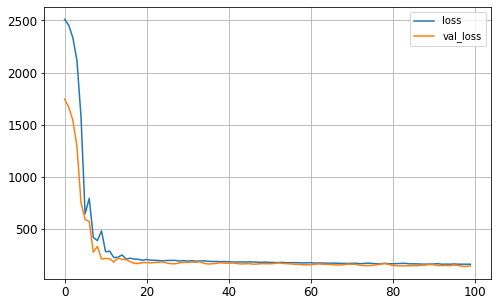

In [12]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
plt.show()

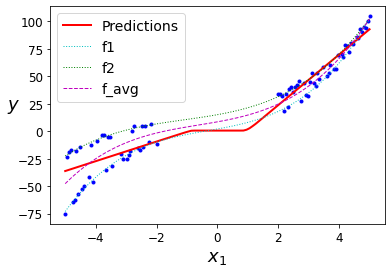

In [13]:
# X_new = np.linspace(-5, 5, 100).reshape(100, 1)
# y_new = model.predict(X_new)
#
plt.plot(X_train, y_train, "b.")
# plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
draw_func(model.predict, mark='r-', linewidth=2, label="Predictions")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()

# Simulated CNN Feature Map (1-D grids, grid --> number)

In [14]:
class num2grid(keras.layers.Layer):
    def __init__(self, units, x_min=-10, x_max=10, sigma=1.0, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.x_min = x_min
        self.x_max = x_max
        self.sigma = sigma
        self.sigma2 = self.sigma**2
        self.activation = keras.activations.get(activation)
        
    def build(self, batch_input_shape):
        #
        self.x_grid = np.linspace(self.x_min, self.x_max, self.units, endpoint=True)
#         print("self.x_grid.shape = %s" % str(self.x_grid.shape))
        #
        super().build(batch_input_shape) # must be at the end
        
    def call(self, X):
        '''
        Input shape:  (batch, X_chanel)
        Output shape: (batch, grid_unit) 
        
        self.x_grid shape: (grid_unit,)
        '''
        gauss_grid = tf.exp( -(self.x_grid - X)**2 / (2.0*self.sigma2) )
        print("X.shape = %s" % str(X.shape))
        print("gauss_grid.shape = %s" % str(gauss_grid.shape))
        return self.activation(gauss_grid)
    
    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 
                "units": self.units,
                "x_min": self.x_min,
                "x_max": self.x_max,
                "sigma": self.sigma,
                "activation": keras.activations.serialize(self.activation)}

In [15]:
model = keras.models.Sequential([
    num2grid(5,x_min=-10, x_max=10, sigma=3.0, input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
#     keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(loss="mean_squared_error", optimizer=optimizer)

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


/home/benson516/ml/my_env/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [16]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

Epoch 1/100
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
1/3 [=========>....................] - ETA: 2s - loss: 2250.3713X.shape = (None, 1)
gauss_grid.shape = (None, 5)
3/3 [==============================] - 2s 267ms/step - loss: 2497.3645 - val_loss: 1728.4834
Epoch 2/100
3/3 [==============================] - 0s 62ms/step - loss: 2424.1863 - val_loss: 1671.6213
Epoch 3/100
3/3 [==============================] - 0s 72ms/step - loss: 2228.8687 - val_loss: 1519.5679
Epoch 4/100
3/3 [==============================] - ETA: 0s - loss: 1709.38 - 0s 95ms/step - loss: 1755.7565 - val_loss: 1320.7677
Epoch 5/100
3/3 [==============================] - 0s 104ms/step - loss: 1115.2220 - val_loss: 937.1193
Epoch 6/100
3/3 [==============================] - 0s 57ms/step - loss: 704.6941 - val_loss: 588.8807
Epoch 7/100
3/3 [==============================] - 0s 74ms/step - loss: 489.2846 - val_loss: 381.3567
Epoch 8/100
3/3 [=====================

Epoch 78/100
3/3 [==============================] - 0s 68ms/step - loss: 162.7330 - val_loss: 117.8062
Epoch 79/100
3/3 [==============================] - 0s 111ms/step - loss: 160.4156 - val_loss: 113.0655
Epoch 80/100
3/3 [==============================] - 0s 102ms/step - loss: 160.1894 - val_loss: 110.4764
Epoch 81/100
3/3 [==============================] - 0s 100ms/step - loss: 161.7316 - val_loss: 116.6751
Epoch 82/100
3/3 [==============================] - 0s 66ms/step - loss: 160.0897 - val_loss: 121.7720
Epoch 83/100
3/3 [==============================] - 0s 71ms/step - loss: 160.8222 - val_loss: 120.6087
Epoch 84/100
3/3 [==============================] - 0s 76ms/step - loss: 163.1281 - val_loss: 128.3906
Epoch 85/100
3/3 [==============================] - 0s 106ms/step - loss: 160.1960 - val_loss: 113.2570
Epoch 86/100
3/3 [==============================] - 0s 117ms/step - loss: 162.1689 - val_loss: 108.3830
Epoch 87/100
3/3 [==============================] - 0s 68ms/step - l

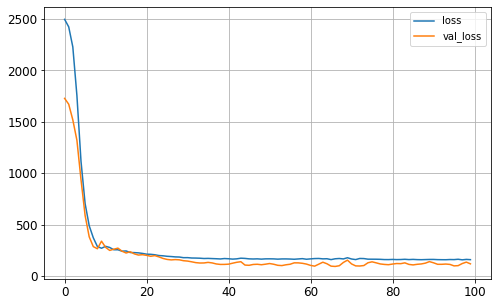

In [17]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
plt.show()

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


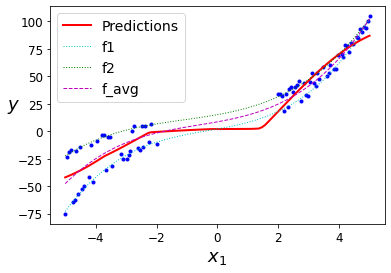

In [18]:
# X_new = np.linspace(-5, 5, 100).reshape(100, 1)
# y_new = model.predict(X_new)
#
plt.plot(X_train, y_train, "b.")
# plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
draw_func(model.predict, mark='r-', linewidth=2, label="Predictions")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()

# Grid & Regression by Classification (grid --> grid)

In [19]:
class num2grid_np():
    def __init__(self, units, x_min=-10, x_max=10, sigma=1.0):
        self.units = units
        self.x_min = x_min
        self.x_max = x_max
        self.sigma = sigma
        self.sigma2 = self.sigma**2
        self.x_grid = np.linspace(self.x_min, self.x_max, self.units, endpoint=True)
        print("self.x_grid = %s" % str(self.x_grid))
        
    def convert(self, X):
        gauss_grid = np.exp( -(self.x_grid - X)**2 / (2.0*self.sigma2) )
#         if len(gauss_grid.shape) == 1:
#             gauss_grid = gauss_grid.reshape([1,-1])
#         grid_sum = np.sum(gauss_grid, axis=1, keepdims=True)
        grid_sum = np.sum(gauss_grid, axis=-1, keepdims=True)
        gauss_grid = gauss_grid / grid_sum
        return gauss_grid
    
    def inv_convert(self, grid):
#         if len(grid.shape) == 1:
#             grid = grid.reshape([1,-1])
#         grid_sum = np.sum(grid, axis=1)
        grid_sum = np.sum(grid, axis=-1)
#         print(grid_sum)
        exp_num = np.sum((self.x_grid * grid), axis=-1) / grid_sum # element-wise
        return exp_num
    
    def get_statistic(self, grid):
        grid_sum = np.sum(grid, axis=-1)
        _mean = np.sum((self.x_grid * grid), axis=-1) / grid_sum # element-wise
        _var  = np.sum( ((self.x_grid.reshape((1,-1)) - _mean.reshape((-1,1)))**2 * grid), axis=-1) / grid_sum # element-wise
        # print("(_mean, _var) = (%f, %f)" % (_mean, _var))
        _stddev = np.sqrt(_var)
        return _mean, _stddev

In [20]:
# class_num = 10 # 10
# n2g = num2grid_np(class_num, x_min=-100.0, x_max=100.0, sigma=20.0) # 20.0
# class_num = 20
# n2g = num2grid_np(class_num, x_min=-100.0, x_max=100.0, sigma=10.0) # 20.0
class_num = 50
n2g = num2grid_np(class_num, x_min=-100.0, x_max=100.0, sigma=5.0) # 5.0 

self.x_grid = [-100.          -95.91836735  -91.83673469  -87.75510204  -83.67346939
  -79.59183673  -75.51020408  -71.42857143  -67.34693878  -63.26530612
  -59.18367347  -55.10204082  -51.02040816  -46.93877551  -42.85714286
  -38.7755102   -34.69387755  -30.6122449   -26.53061224  -22.44897959
  -18.36734694  -14.28571429  -10.20408163   -6.12244898   -2.04081633
    2.04081633    6.12244898   10.20408163   14.28571429   18.36734694
   22.44897959   26.53061224   30.6122449    34.69387755   38.7755102
   42.85714286   46.93877551   51.02040816   55.10204082   59.18367347
   63.26530612   67.34693878   71.42857143   75.51020408   79.59183673
   83.67346939   87.75510204   91.83673469   95.91836735  100.        ]


In [21]:
# grid_1 = n2g.convert(-1.2)
grid_1 = n2g.convert([[-1.2]])
print(grid_1)

[[5.32087956e-86 3.86113319e-79 1.43892139e-72 2.75391345e-66
  2.70678923e-60 1.36631087e-54 3.54189384e-49 4.71533431e-44
  3.22389115e-39 1.13198112e-34 2.04121584e-30 1.89029511e-26
  8.99003166e-23 2.19575442e-19 2.75421121e-16 1.77419623e-13
  5.86944439e-11 9.97202289e-09 8.70082579e-07 3.89877895e-05
  8.97196734e-04 1.06032179e-02 6.43544562e-02 2.00590561e-01
  3.21094817e-01 2.63965415e-01 1.11442718e-01 2.41628020e-02
  2.69050515e-03 1.53854886e-04 4.51834812e-06 6.81457879e-08
  5.27824177e-10 2.09957055e-12 4.28906472e-15 4.49972175e-18
  2.42437419e-21 6.70817796e-25 9.53235992e-29 6.95644285e-33
  2.60714354e-37 5.01803398e-42 4.96013143e-47 2.51793030e-52
  6.56425064e-58 8.78855631e-64 6.04283668e-70 2.13380686e-76
  3.86954844e-83 3.60376450e-90]]


In [22]:
n2g.inv_convert(grid_1)

array([-1.2])

In [23]:
n2g.get_statistic(grid_1)

(array([-1.2]), array([5.]))

### Convert the labels to grid (pre-processing)

In [24]:
y_train_grid = n2g.convert(y_train)
y_valid_grid = n2g.convert(y_valid)

In [25]:
print(y_train_grid.shape)
print(y_valid_grid.shape)

(80, 50)
(20, 50)


In [26]:
model = keras.models.Sequential([
#     keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    num2grid(5,x_min=-10, x_max=10, sigma=3.0, input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(class_num, activation="softmax"),
])

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


/home/benson516/ml/my_env/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [27]:
history = model.fit(X_train, y_train_grid, epochs=100,
                    validation_data=(X_valid, y_valid_grid))

Epoch 1/100
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
1/3 [=========>....................] - ETA: 1s - loss: 3.9493X.shape = (None, 1)
gauss_grid.shape = (None, 5)
3/3 [==============================] - 2s 388ms/step - loss: 3.9359 - val_loss: 3.9218
Epoch 2/100
3/3 [==============================] - 0s 78ms/step - loss: 3.8862 - val_loss: 3.8806
Epoch 3/100
3/3 [==============================] - 0s 83ms/step - loss: 3.8135 - val_loss: 3.8370
Epoch 4/100
3/3 [==============================] - 0s 71ms/step - loss: 3.7291 - val_loss: 3.7964
Epoch 5/100
3/3 [==============================] - 0s 92ms/step - loss: 3.6363 - val_loss: 3.7519
Epoch 6/100
3/3 [==============================] - 0s 88ms/step - loss: 3.5287 - val_loss: 3.6981
Epoch 7/100
3/3 [==============================] - 0s 85ms/step - loss: 3.4251 - val_loss: 3.6316
Epoch 8/100
3/3 [==============================] - 0s 60ms/step - loss: 3.3236 - val_loss: 3.5415
Epoch 9

3/3 [==============================] - 0s 87ms/step - loss: 2.3490 - val_loss: 2.5642
Epoch 82/100
3/3 [==============================] - 0s 77ms/step - loss: 2.3652 - val_loss: 2.5712
Epoch 83/100
3/3 [==============================] - 0s 69ms/step - loss: 2.3540 - val_loss: 2.5810
Epoch 84/100
3/3 [==============================] - 0s 78ms/step - loss: 2.3491 - val_loss: 2.5242
Epoch 85/100
3/3 [==============================] - 0s 72ms/step - loss: 2.3541 - val_loss: 2.4453
Epoch 86/100
3/3 [==============================] - 0s 75ms/step - loss: 2.3552 - val_loss: 2.5234
Epoch 87/100
3/3 [==============================] - 0s 106ms/step - loss: 2.3420 - val_loss: 2.5705
Epoch 88/100
3/3 [==============================] - 0s 95ms/step - loss: 2.3465 - val_loss: 2.5501
Epoch 89/100
3/3 [==============================] - 0s 110ms/step - loss: 2.3318 - val_loss: 2.6270
Epoch 90/100
3/3 [==============================] - 0s 93ms/step - loss: 2.3446 - val_loss: 2.6340
Epoch 91/100
3/3 [===

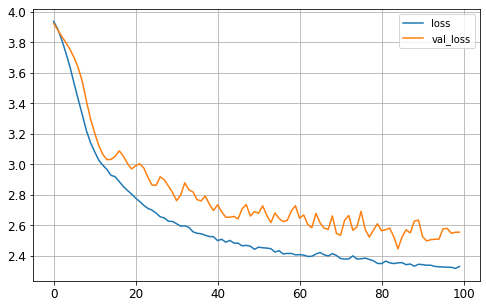

In [28]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
plt.show()

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


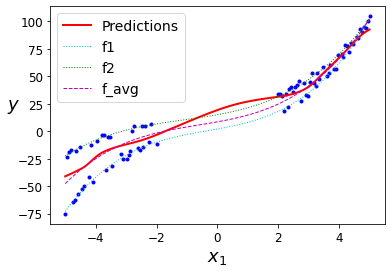

In [29]:
# X_new = np.linspace(-5, 5, 100).reshape(100, 1)
# y_new_proba = model.predict(X_new)
# y_new = n2g.inv_convert(y_new_proba)
#
plt.plot(X_train, y_train, "b.")
# plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
draw_func((lambda X: n2g.inv_convert(model.predict(X)) ), mark='r-', linewidth=2, label="Predictions")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()

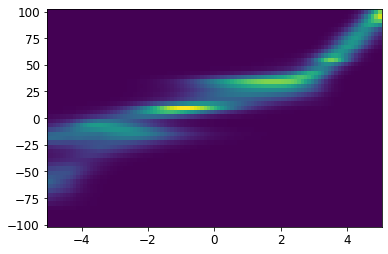

In [30]:
X_new = np.linspace(-5, 5, 100).reshape(100, 1)
y_new_proba = model.predict(X_new)
# y_new = n2g.inv_convert(y_new_proba)
#
xv, yv = np.meshgrid(X_new, np.linspace(n2g.x_min, n2g.x_max, n2g.units))
# print(xv)
# print(yv)
plt.pcolormesh(xv, yv, y_new_proba.T, shading="nearest")

### Draw the 1-sigma boundary line

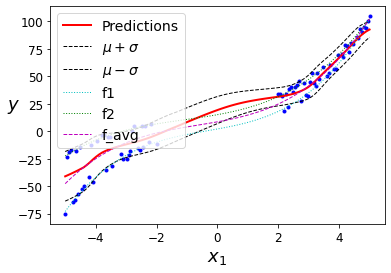

In [31]:
def n_sigma_boundary_line(X, n):
    _mean, _sigma = n2g.get_statistic(model.predict(X))
    return( _mean + n*_sigma)

plt.plot(X_train, y_train, "b.")
#
draw_func((lambda X: n2g.inv_convert(model.predict(X)) ), mark='r-', linewidth=2, label="Predictions")
draw_func((lambda X: n_sigma_boundary_line(X, +1.0) ), mark='k--', linewidth=1, label="$\mu+\sigma$")
draw_func((lambda X: n_sigma_boundary_line(X, -1.0) ), mark='k--', linewidth=1, label="$\mu-\sigma$")
#
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()

# Grid & Regression by Classification + Offset Estimation (grid --> grid,num)

In [32]:
class num2gridOffset_np():
    def __init__(self, units, x_min=-10, x_max=10):
        self.units = units
        self.x_min = x_min
        self.x_max = x_max
        self.x_grid = np.linspace(self.x_min, self.x_max, self.units, endpoint=True)
        # bins
        x_space = np.average(self.x_grid[1:] - self.x_grid[:-1])
        print("x_space = %f" % x_space)
        x_0 = self.x_grid[0] - 0.5 * x_space
        self.x_bins = [x_0 + _i*x_space for _i in range(len(self.x_grid)+1)]
        print("self.x_grid = %s" % str(self.x_grid))
#         print("self.x_bins = %s" % str(self.x_bins))
        
    def convert(self, X):
        '''
        Convert a batch of number to one-hot class and numerical offset to each grid's center
        (m, 1) --> (m, n_units, 2)
        '''
        X = np.array(X)
        if len(X.shape) <= 1:
            X = X.reshape((-1,1))
        idxs_bin = np.digitize(X, self.x_bins, right=False) 
        idxs_grid = (idxs_bin - 1) + 1*(idxs_bin<= 0)
        print(idxs_grid.shape)
        #
        batch_size = X.shape[0]
        grid = np.zeros((batch_size, self.units, 2))
        # Fill in the values
        grid[np.arange(batch_size), idxs_grid.reshape((-1,)), 0] = 1.0
        grid[np.arange(batch_size), :, 1] = X - self.x_grid.reshape((1,-1)) # Offset
        return grid
    
    def inv_convert(self, grid):
        idxs_grid = np.argmax(grid[...,0], axis=1)
        print(idxs_grid.shape)
        #
        batch_size = grid.shape[0]
        offset_est = grid[np.arange(batch_size),idxs_grid,1]
        print(offset_est.shape)
        num_est = self.x_grid[idxs_grid].reshape((1,-1)) + offset_est
        return num_est.reshape((-1,))

In [33]:
class_num = 10 # 10
n2go = num2gridOffset_np(class_num, x_min=-100.0, x_max=100.0) 

x_space = 22.222222
self.x_grid = [-100.          -77.77777778  -55.55555556  -33.33333333  -11.11111111
   11.11111111   33.33333333   55.55555556   77.77777778  100.        ]


In [34]:
# grid_1 = n2g.convert(-1.2)
grid_1 = n2go.convert([[-1.2], [50.5]])
print(grid_1)

(2, 1)
[[[   0.           98.8       ]
  [   0.           76.57777778]
  [   0.           54.35555556]
  [   0.           32.13333333]
  [   1.            9.91111111]
  [   0.          -12.31111111]
  [   0.          -34.53333333]
  [   0.          -56.75555556]
  [   0.          -78.97777778]
  [   0.         -101.2       ]]

 [[   0.          150.5       ]
  [   0.          128.27777778]
  [   0.          106.05555556]
  [   0.           83.83333333]
  [   0.           61.61111111]
  [   0.           39.38888889]
  [   0.           17.16666667]
  [   1.           -5.05555556]
  [   0.          -27.27777778]
  [   0.          -49.5       ]]]


In [35]:
n2go.inv_convert(grid_1)

(2,)
(2,)


array([-1.2, 50.5])

### Convert the labels to grid (pre-processing)

In [36]:
y_train_grid_offset = n2go.convert(y_train)
y_valid_grid_offset = n2go.convert(y_valid)

(80, 1)
(20, 1)


In [37]:
print(y_train_grid_offset.shape)
print(y_valid_grid_offset.shape)

(80, 10, 2)
(20, 10, 2)


In [38]:
inputs = keras.layers.Input(shape=X_train.shape[1:])
#
z = num2grid(5,x_min=-10, x_max=10, sigma=3.0)(inputs)
z = keras.layers.Dense(30, activation="selu")(z)
# Outputs
z_proba = keras.layers.Dense(30, activation="relu")(z)
z_proba  = keras.layers.Dense(class_num, activation="softmax")(z_proba)
z_offset = keras.layers.Dense(class_num, activation="relu")(z)
z_offset = keras.layers.Dense(class_num)(z_offset)
# Concatenate
z_proba  = keras.layers.Reshape([class_num,1])(z_proba)
z_offset = keras.layers.Reshape([class_num,1])(z_offset)
out_cat = keras.layers.Concatenate(axis=-1)([z_proba, z_offset])
#
# Models for trainig and real usage
model = keras.Model(inputs=[inputs], outputs=[out_cat])

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


In [39]:
# Customized loss function

cce = keras.losses.CategoricalCrossentropy(reduction=keras.losses.Reduction.NONE)
# cce(y_true, y_pred).numpy()

def centerLoss_fn(y_true, y_pred):
    #
    y_true_proba = y_true[...,0]
    y_true_value = y_true[...,1]
    #
    y_pred_proba = y_pred[...,0]
    y_pred_value = y_pred[...,1]
    
    #
    cce_loss = cce(y_true_proba, y_pred_proba) / class_num
    #
    y_true_value_est = tf.reduce_sum((y_true_proba * y_true_value), axis=-1)
    y_pred_value_est = tf.reduce_sum((y_true_proba * y_pred_value), axis=-1)
#     y_pred_value_est = tf.reduce_sum((y_pred_proba * y_pred_value), axis=-1)
    value_loss = tf.abs(y_pred_value_est - y_true_value_est)
    
    # Total loss
#     return (0.5*cce_loss + 0.5*value_loss )
    return (0.2*cce_loss + 0.8*value_loss )
#     return (cce_loss)
#     return (value_loss )

In [40]:
optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9)
model.compile(loss=centerLoss_fn, optimizer=optimizer)

/home/benson516/ml/my_env/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [41]:
history = model.fit(X_train, y_train_grid_offset, epochs=100,
                    validation_data=(X_valid, y_valid_grid_offset))

Epoch 1/100
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
1/3 [=========>....................] - ETA: 5s - loss: 4.3763X.shape = (None, 1)
gauss_grid.shape = (None, 5)
3/3 [==============================] - 3s 291ms/step - loss: 4.3189 - val_loss: 5.6214
Epoch 2/100
3/3 [==============================] - 0s 99ms/step - loss: 4.2699 - val_loss: 5.6454
Epoch 3/100
3/3 [==============================] - 0s 89ms/step - loss: 4.2197 - val_loss: 5.7265
Epoch 4/100
3/3 [==============================] - 0s 100ms/step - loss: 4.1387 - val_loss: 5.7578
Epoch 5/100
3/3 [==============================] - 0s 61ms/step - loss: 4.0731 - val_loss: 5.6587
Epoch 6/100
3/3 [==============================] - 0s 56ms/step - loss: 4.0083 - val_loss: 5.3952
Epoch 7/100
3/3 [==============================] - 0s 73ms/step - loss: 3.9598 - val_loss: 4.9404
Epoch 8/100
3/3 [==============================] - 0s 120ms/step - loss: 3.8951 - val_loss: 4.6675
Epoch

3/3 [==============================] - 0s 114ms/step - loss: 3.4056 - val_loss: 4.2483
Epoch 82/100
3/3 [==============================] - 0s 114ms/step - loss: 3.5113 - val_loss: 4.8827
Epoch 83/100
3/3 [==============================] - 0s 129ms/step - loss: 3.6976 - val_loss: 3.6710
Epoch 84/100
3/3 [==============================] - 0s 91ms/step - loss: 4.1680 - val_loss: 3.8752
Epoch 85/100
3/3 [==============================] - 0s 103ms/step - loss: 3.9847 - val_loss: 4.6414
Epoch 86/100
3/3 [==============================] - 0s 121ms/step - loss: 3.8184 - val_loss: 4.8902
Epoch 87/100
3/3 [==============================] - 0s 98ms/step - loss: 3.8400 - val_loss: 4.7464
Epoch 88/100
3/3 [==============================] - 0s 81ms/step - loss: 3.8015 - val_loss: 4.5736
Epoch 89/100
3/3 [==============================] - 0s 92ms/step - loss: 3.7617 - val_loss: 4.7680
Epoch 90/100
3/3 [==============================] - 0s 134ms/step - loss: 3.8141 - val_loss: 4.9156
Epoch 91/100
3/3 

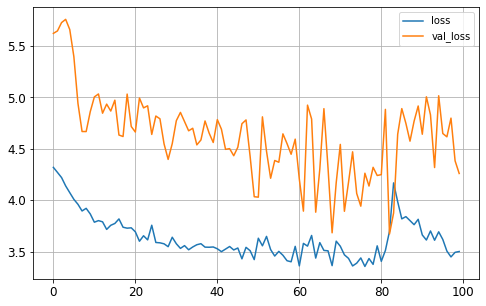

In [42]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
plt.show()

X.shape = (None, 1)
gauss_grid.shape = (None, 5)
(100,)
(100,)


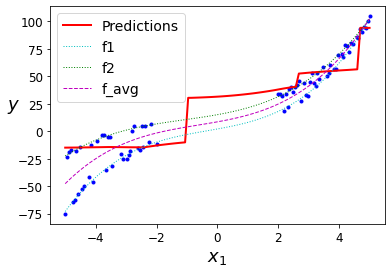

In [43]:
plt.plot(X_train, y_train, "b.")
draw_func((lambda X: n2go.inv_convert(model.predict(X)) ), mark='r-', linewidth=2, label="Predictions")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()